In [2]:
import os, pyBigWig
# import anndata
import glob, gzip
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import pysam
import edlib
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BamFile, BedFile
from pyBioInfo.Utils import BundleBuilder, ShiftLoader
infos = pd.read_excel("NanoNASCseq.xls")
# infos.head()

# Cell counts

In [13]:
dat = pd.read_csv("results/nascent/summary.tsv", sep="\t")
dat = dat[(dat["Platform"] == "R10") \
          & (np.isnan(dat["ActD"])) \
          & (dat["UMI"] == 20) \
          & (dat["Cells"] == 1) \
          & (dat["Reads"] > 0) \
          & (dat["T2C"] > 0)]
dat = dat[dat["Run"] != "20220818_mESCR3P2"]
dat = dat[dat["Run"] != "20220902_Blastocyst"]
dat = dat[dat["Run"] != "20220903_Blastocyst"]
counter = Counter([tuple(items) for items in dat[["Species", "Strain", "s4U", "Time"]].values])
print(len(dat))

4035


In [14]:
dat1 = dat[(dat["Reads"] > 1e5) & (dat["T2C"] > 0.01) & (dat["RNAs"] > 4000) & (dat["Genes"] > 0) & (dat["NascentRatio"] > 0.1)]
counter1 = Counter([tuple(items) for items in dat1[["Species", "Strain", "s4U", "Time"]].values])

In [15]:
rows = []
for k in sorted(counter):
    species, strain, s4u, time = k
    count1, count2 = counter[k], counter1[k]
    rows.append([species, strain, s4u, time, count1, count2])
df = pd.DataFrame(rows)
df.columns = ["Species", "Strain", "s4U", "Time", "Cells", "FilteredCells"]
df.to_excel("results/nascent/stat_cell_count.xlsx", index=False)

In [16]:
print("Cells\tPass\tRatio\tRun")
print("--------------------------------------")
for run, tmp in dat.groupby(by="Run"):
    d1 = tmp[(tmp["s4U"] == 400) & (tmp["Time"] == 3) & (tmp["Species"] == "Mouse")]
    d2 = d1[(d1["Reads"] > 1e5) & (d1["T2C"] > 0.01) & (d1["RNAs"] > 4000) & (d1["NascentRatio"] > 0.1)]
    if len(d1) == 0:
        continue
    r = len(d2) / len(d1)
    print(len(d1), len(d2), "%.4f" % r, run, sep="\t")

Cells	Pass	Ratio	Run
--------------------------------------
11	0	0.0000	20220719_Embryo
17	5	0.2941	20220729_EmbryoR10
3	1	0.3333	20220729_K562R3
19	7	0.3684	20220808_Blastocyst
21	0	0.0000	20220817_Embryo
42	35	0.8333	20220818_mESCR2
80	67	0.8375	20220818_mESCR3
11	6	0.5455	20220820_Embryo
31	5	0.1613	20220823_MidBlast
28	15	0.5357	20220824_MidBlast
69	36	0.5217	20220831_MidBlast
46	14	0.3043	20220902_BlastocystS1
18	6	0.3333	20220903_BlastocystS1
63	21	0.3333	20220924_Blastocyst
72	15	0.2083	20221008_Blastocyst
67	5	0.0746	20221018_Blastocyst
53	8	0.1509	20221019_BlastocystS1
62	9	0.1452	20221031_Blastocyst
74	22	0.2973	20221031_Blastocyst2
80	47	0.5875	20221120_Blastocyst
76	34	0.4474	20221122_Blastocyst
74	15	0.2027	20221126_Blastocyst
61	25	0.4098	20221127_Blastocyst
56	22	0.3929	20221128_Blastocyst
63	16	0.2540	20221129_Blastocyst
68	22	0.3235	20221207_Blastocyst
70	17	0.2429	20221207_Blastocyst2
74	48	0.6486	20221207_Blastocyst3
83	34	0.4096	20221217_BlastocystC70
86	9	0.1047	20

In [19]:
tmp = dat[dat["Run"] == "20221217_BlastocystC73"]
print(len(tmp))
print(sum(tmp["Reads"] > 1e5))
print(sum(tmp["T2C"] > 0.01))
print(sum(tmp["RNAs"] > 4000))
print(sum(tmp["NascentRatio"] > 0.1))

86
80
12
60
58


# Statistic

In [20]:
dat = pd.read_csv("results/nascent/summary.tsv", sep="\t")
dat = dat[(dat["Species"] == "Mouse") \
          & (dat["Platform"] == "R10") \
          & (dat["s4U"] == 400) \
          & (dat["Time"] == 3) \
          & (dat["Cells"] == 1) & (dat["Reads"] > 0) & (dat["T2C"] > 0)]
strains = [
 'Early-blastocyst',
 'Mid-blastocyst',
 'Late-blastocyst',
 'Early-blastocystX',
 'Mid-blastocystX',
 'Late-blastocystX',
 'mESC']
dat = dat[dat["Run"] != "20220818_mESCR3P2"]
dat = dat[dat["Run"] != "20220902_Blastocyst"]
dat = dat[dat["Run"] != "20220903_Blastocyst"]
dat = dat[[s in strains for s in dat["Strain"]]]
print(len(dat))
print(dat.columns)
print("-" * 80)
for k, v in Counter(dat["Strain"]).items():
    print(v, k, sep="\t")

2818
Index(['Run', 'Cell', 's4U', 'Time', 'ActD', 'Barcode', 'UMI', 'Strain',
       'Cells', 'Group', 'LibStruct', 'Platform', 'Species', 'Remark',
       'Paternal', 'Reads', 'Genes', 'ProteinCoding', 'LincRNA', 'T2C', 'RNAs',
       'NascentRNAs', 'NascentRatio', 'NascentGenes', 'NascentProteinCoding',
       'NascentLincRNA'],
      dtype='object')
--------------------------------------------------------------------------------
170	Early-blastocyst
301	Late-blastocyst
147	Mid-blastocyst
122	mESC
922	Late-blastocystX
648	Early-blastocystX
508	Mid-blastocystX


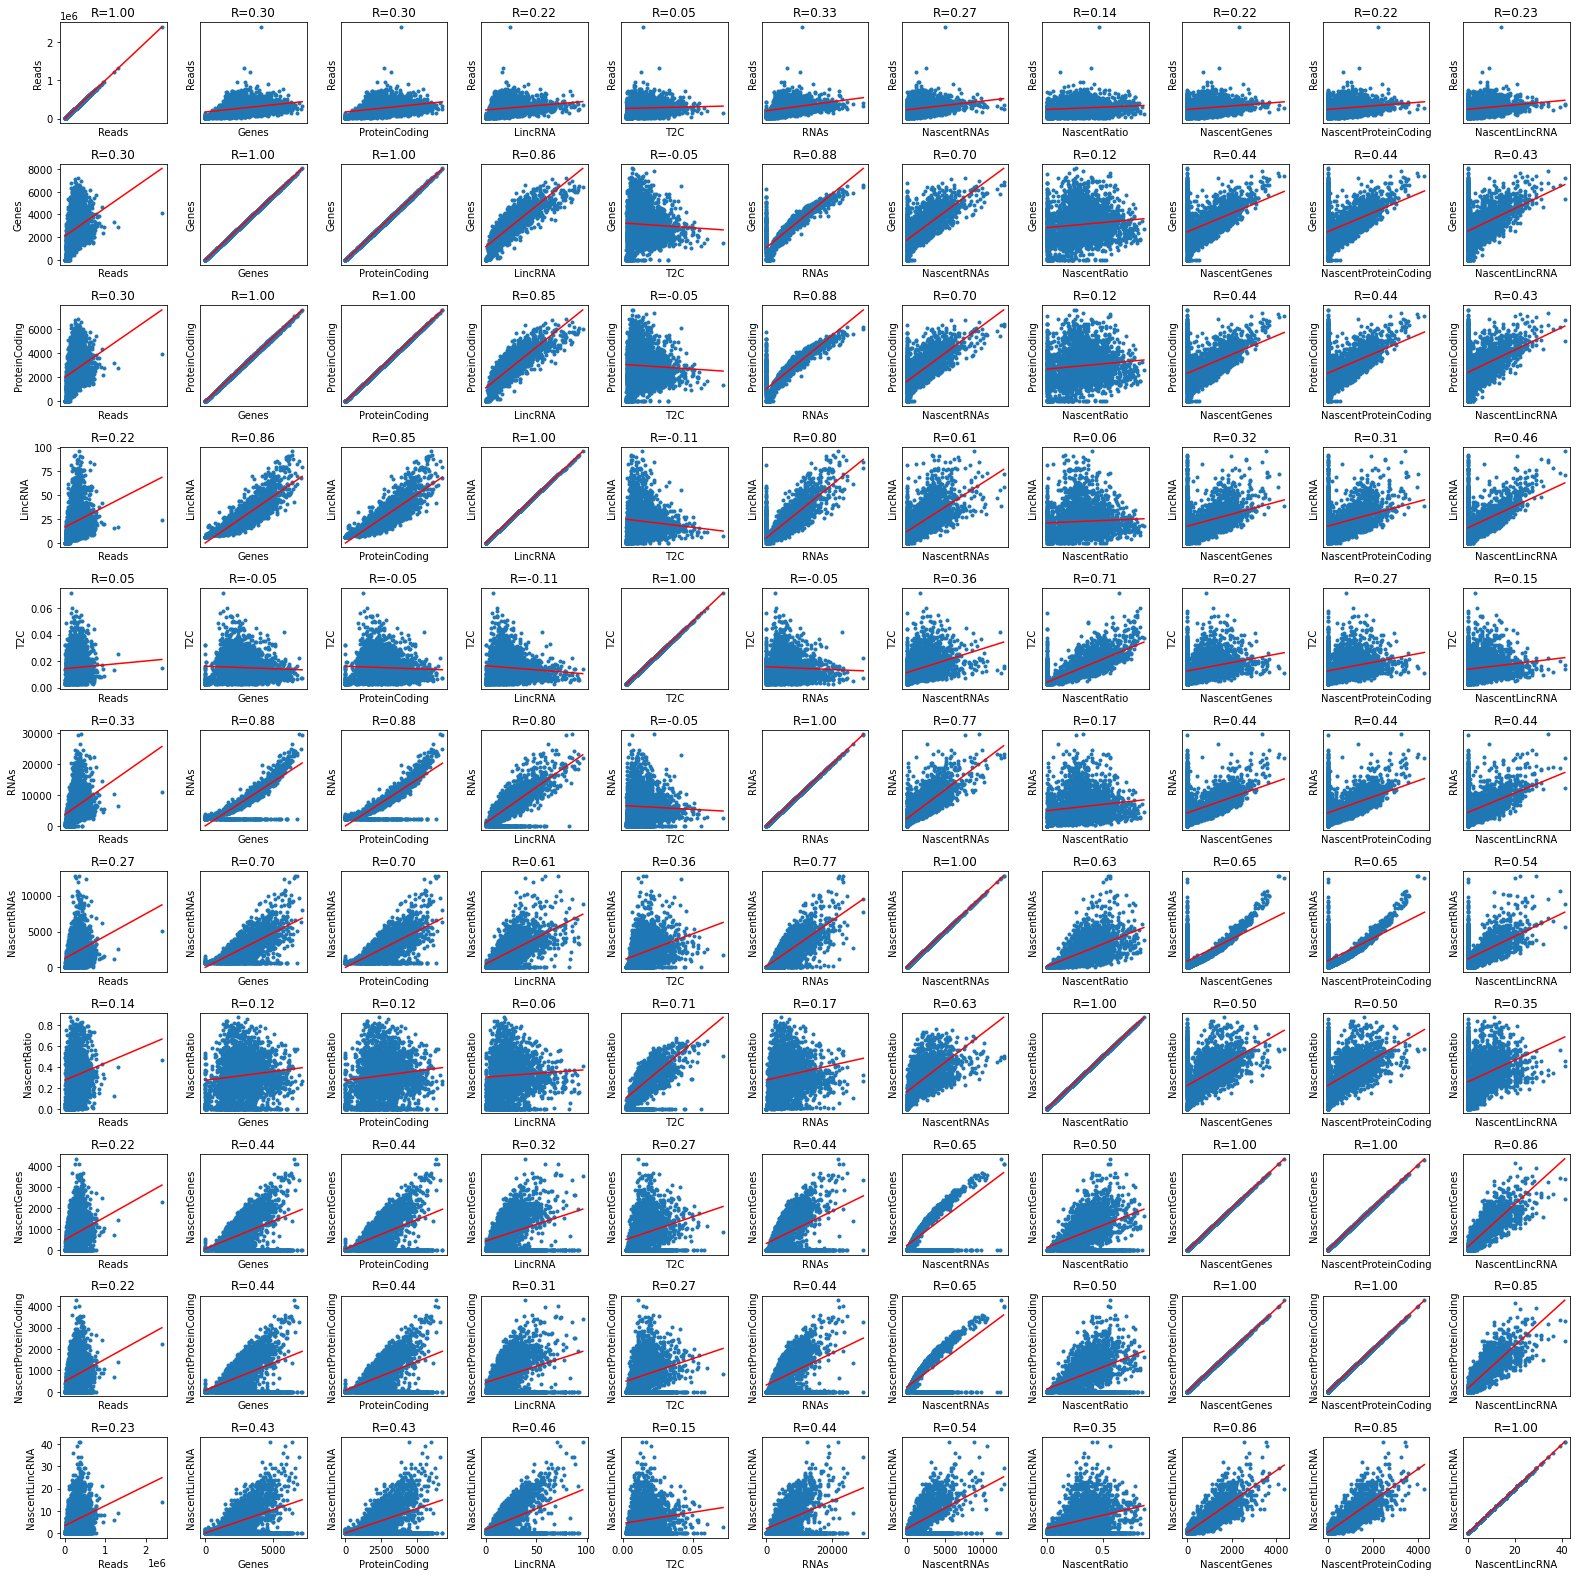

In [21]:
columns = ['Reads', 'Genes', 'ProteinCoding', 'LincRNA', 'T2C', 'RNAs', 
           'NascentRNAs', 'NascentRatio', 'NascentGenes', 'NascentProteinCoding',
           'NascentLincRNA']
# columns = columns[:3]
fig, axs = plt.subplots(len(columns), len(columns), figsize=(2 * len(columns), 2 * len(columns)))
for i in range(len(columns)):
    for j in range(len(columns)):
        ax = axs[i][j]
        c1 = columns[j]
        c2 = columns[i]
        plt.sca(ax)
        xs = dat[c1]
        ys = dat[c2]
        r = np.corrcoef(xs, ys)[0][1]
        # print(r)
        plt.title("R=%.2f" % r)
        a, b = np.polyfit(xs, ys, 1)
        plt.scatter(xs, ys, marker=".")
        plt.plot([min(xs), max(xs)], 
                 [min(xs) * a + b, max(xs) * a + b], color="red")
        if i < len(columns) - 1:
            plt.xticks([])
        plt.xlabel(c1)
        if j > 0:
            plt.yticks([])
        plt.ylabel(c2)
plt.tight_layout()
plt.savefig("pairwise_correlation.pdf", dpi=300)

In [22]:
dat1 = dat[(dat["Reads"] > 1e5) & (dat["T2C"] > 0.005) & (dat["RNAs"] > 1000) & (dat["Genes"] > 3000) & (dat["NascentRatio"] > 0.1)]
for k, v in Counter(dat1["Strain"]).items():
    print(v, k, sep="\t")
dat1.to_csv("results/nascent/selected_cells.tsv", sep="\t", index=False)

38	Early-blastocyst
22	Late-blastocyst
42	mESC
39	Mid-blastocyst
274	Late-blastocystX
259	Early-blastocystX
303	Mid-blastocystX


In [23]:
dat1 = dat[(dat["Reads"] > 1e5) & (dat["T2C"] > 0.005) & (dat["RNAs"] > 1000) & (dat["Genes"] > 3000) & (dat["NascentRatio"] > 0.1)]
for k, v in Counter(dat1["Strain"]).items():
    print(v, k, sep="\t")
dat1.to_csv("results/nascent/selected_cells.tsv", sep="\t", index=False)

38	Early-blastocyst
22	Late-blastocyst
42	mESC
39	Mid-blastocyst
274	Late-blastocystX
259	Early-blastocystX
303	Mid-blastocystX


# Benchmark of half-life

In [10]:
d1 = pd.read_csv("results/halflife/NanoNASCseq_K562_50uM_3h_145cells.tsv", sep="\t", index_col=0)
d1 = d1[~d1["GeneName"].duplicated()]
d1.index = d1["GeneName"]
d2 = pd.read_csv("../2_NASCseq/results/halflife/NASC-seq_K562_50uM_3h.tsv", sep="\t", index_col=0)
d3 = pd.read_csv("../2_NASCseq/results/halflife/GSE128273_K562_50uM_3h.tsv", sep="\t", index_col=0)
d4 = pd.read_csv("../4_RNAseq_ActD/results/halflife/20221128_AtcD_halflife.tsv", sep="\t", index_col=0)
d5 = pd.read_csv("../4_RNAseq_ActD/results/halflife/20221205_AtcD_halflife.tsv", sep="\t", index_col=0)
array = [d1, d2, d3, d4, d5]
for d in array:
    print(len(d))

13599
244939
244939
244939
244939


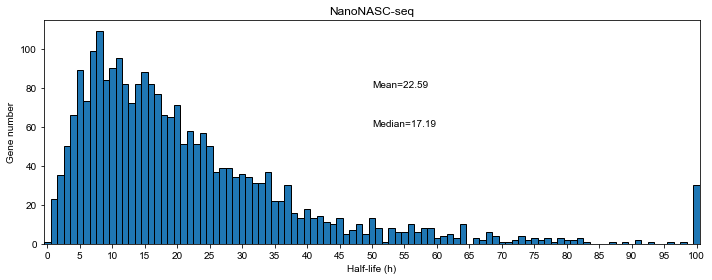

In [3]:
df = d1[(d1["Total"] > 50) & (d1["Nascent"] > 0)]

ys = np.zeros(101)
for t in df["T"]:
    ys[min(int(t), len(ys) - 1)] += 1
xs = np.arange(len(ys))

plt.figure(figsize=(10, 4))
plt.title("NanoNASC-seq")
plt.bar(xs, ys, width=1, edgecolor="black")
plt.text(50, 80, "Mean=%.2f" % np.mean(df["T"]))
plt.text(50, 60, "Median=%.2f" % np.median(df["T"]))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.xticks(np.arange(0, len(ys), 5))
plt.xlabel("Half-life (h)")
plt.ylabel("Gene number")
plt.tight_layout()
plt.savefig("figures/k562_half_life_distribution.pdf", dpi=300)

In [89]:
# expression correlation

tmp = d1
s1 = tmp["TPM"]
s1.name = "NanoNASC-seq"

tmp = d2
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding")].copy()
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s2 = tmp["FPKM"]
s2.name = "NASC-seq"

tmp = d3
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding")].copy()
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s3 = tmp["FPKM"]
s3.name = "GSE128273"

tmp = d4
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding")].copy()
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s4 = tmp[["0h-1", "0h-2"]].mean(axis=1)
s4.name = "RNAseq1"

tmp = d5
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding")].copy()
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s5 = tmp[["0h-1", "0h-2"]].mean(axis=1)
s5.name = "RNAseq2"

dat = pd.concat([s1, s2, s3, s4, s5], axis=1, sort=False, join="inner")
print(len(dat))

10655


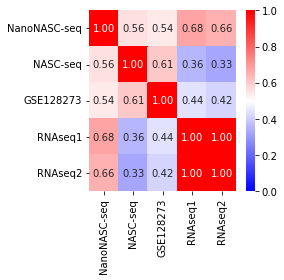

In [91]:
plt.figure(figsize=(4, 4))
sns.heatmap(dat.corr(), vmin=0, vmax=1, cmap="bwr", annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig("figures/k562_50uM_3h_expression_corr.pdf", dpi=300)

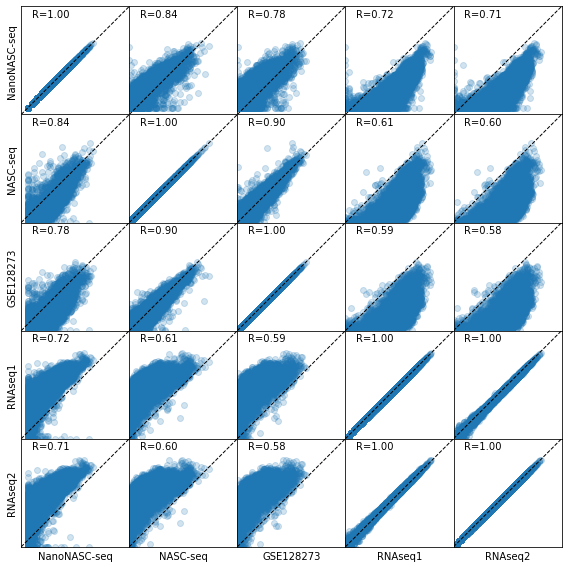

In [102]:
fig, axs = plt.subplots(len(dat.columns), len(dat.columns), figsize=(8, 8), gridspec_kw={"hspace": 0, "wspace": 0})
for i in range(len(dat.columns)):
    for j in range(len(dat.columns)):
        c1 = dat.columns[i]
        c2 = dat.columns[j]
        xs = np.log2(dat[c1].values + 1)
        ys = np.log2(dat[c2].values + 1)
        r = np.corrcoef(xs, ys)[0][1]
        ax = axs[j][i]
        plt.sca(ax)
        plt.scatter(xs, ys, alpha=0.2)
        plt.plot([0, 20], [0, 20], lw=1, ls="--", color="black")
        plt.xlim(0, 20)
        plt.ylim(0, 20)
        plt.text(2, 18, "R=%.2f" % r)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(c2)
        if j == len(dat.columns) - 1:
            plt.xlabel(c1)
plt.tight_layout()
plt.savefig("figures/k562_50uM_3h_expression_corr.scatter.pdf", dpi=300)

In [103]:
# half-life

tmp = d1
s1 = tmp[tmp["Total"] >= 50]["T"]
s1.name = "NanoNASC-seq"

tmp = d2
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding") & (tmp["Count"] >= 100)].copy()
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s2 = tmp["T"]
s2.name = "NASC-seq"

tmp = d3
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding") & (tmp["Count"] >= 50)].copy()
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s3 = tmp["T"]
s3.name = "GSE128273"

columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
tmp = d4
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding")].copy()
tmp = tmp[tmp[["0h-1", "0h-2"]].max(axis=1) >= 50]
tmp = tmp[tmp[["0h-1_fpkm", "0h-2_fpkm"]].max(axis=1) >= 10]
tmp = tmp[tmp["D"] < 0.3]
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s4 = tmp["T"]
s4.name = "RNAseq-1"

tmp = d5
tmp = tmp[(tmp["Canonical"]) & (tmp["GeneType"] == "protein_coding")].copy()
tmp = tmp[tmp[["0h-1", "0h-2"]].max(axis=1) >= 50]
tmp = tmp[tmp[["0h-1_fpkm", "0h-2_fpkm"]].max(axis=1) >= 10]
tmp = tmp[tmp["D"] < 0.3]
tmp = tmp[~tmp["GeneName"].duplicated()]
tmp.index = tmp["GeneName"]
s5 = tmp["T"]
s5.name = "RNAseq-2"

dat = pd.concat([s1, s2, s3, s4, s5], axis=1, sort=False, join="inner")
print(len(dat))

1406


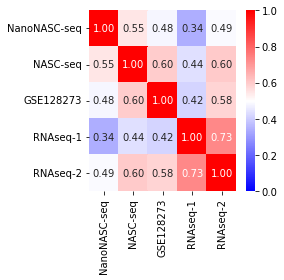

In [105]:
plt.figure(figsize=(4, 4))
sns.heatmap(dat.corr(), vmin=0, vmax=1, cmap="bwr", annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig("figures/k562_50uM_3h_halflife_corr.pdf", dpi=300)

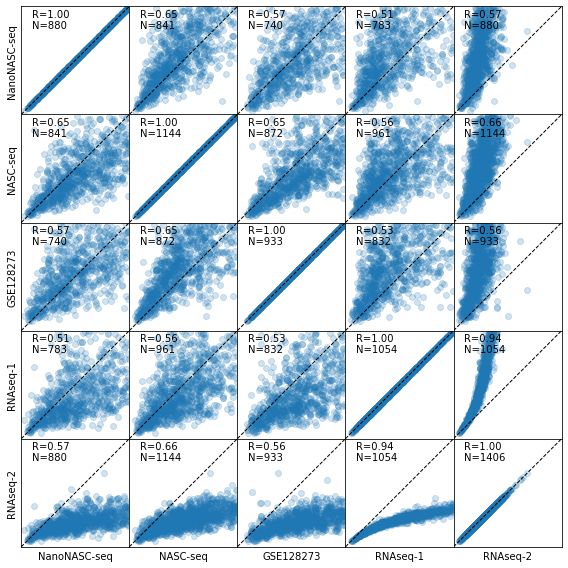

In [112]:
fig, axs = plt.subplots(len(dat.columns), len(dat.columns), figsize=(8, 8), gridspec_kw={"hspace": 0, "wspace": 0})
for i in range(len(dat.columns)):
    for j in range(len(dat.columns)):
        c1 = dat.columns[i]
        c2 = dat.columns[j]
        xs = dat[c1].values
        ys = dat[c2].values
        flags = (xs > 0) & (xs < 20) & (ys > 0) & (ys < 20)
        xs = xs[flags]
        ys = ys[flags]
        r = np.corrcoef(xs, ys)[0][1]
        ax = axs[j][i]
        plt.sca(ax)
        plt.scatter(xs, ys, alpha=0.2)
        plt.plot([0, 20], [0, 20], lw=1, ls="--", color="black")
        plt.xlim(0, 20)
        plt.ylim(0, 20)
        plt.text(2, 18, "R=%.2f" % r)
        plt.text(2, 16, "N=%d" % len(xs))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(c2)
        if j == len(dat.columns) - 1:
            plt.xlabel(c1)
plt.tight_layout()
plt.savefig("figures/k562_50uM_3h_halflife_corr.scatter.pdf", dpi=300)

In [115]:
dat = 1 - 2 ** (-3/dat)

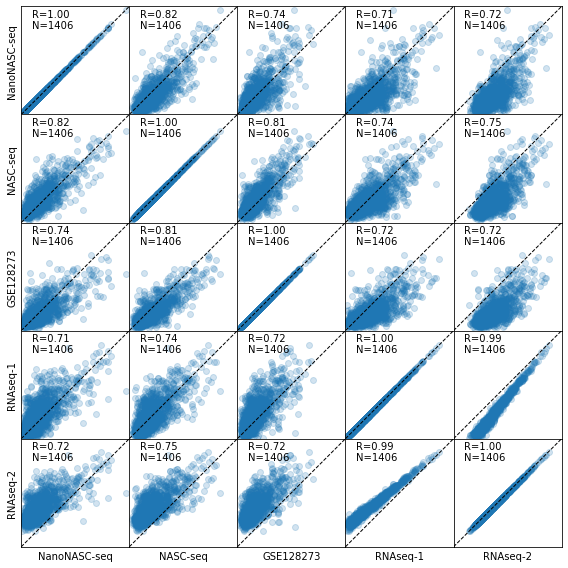

In [117]:
fig, axs = plt.subplots(len(dat.columns), len(dat.columns), figsize=(8, 8), gridspec_kw={"hspace": 0, "wspace": 0})
for i in range(len(dat.columns)):
    for j in range(len(dat.columns)):
        c1 = dat.columns[i]
        c2 = dat.columns[j]
        xs = dat[c1].values
        ys = dat[c2].values
        r = np.corrcoef(xs, ys)[0][1]
        ax = axs[j][i]
        plt.sca(ax)
        plt.scatter(xs, ys, alpha=0.2)
        plt.plot([0, 1], [0, 1], lw=1, ls="--", color="black")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.text(0.1, 0.9, "R=%.2f" % r)
        plt.text(0.1, 0.8, "N=%d" % len(xs))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(c2)
        if j == len(dat.columns) - 1:
            plt.xlabel(c1)
plt.tight_layout()
plt.savefig("figures/k562_50uM_3h_halflife_prop_corr.scatter.pdf", dpi=300)

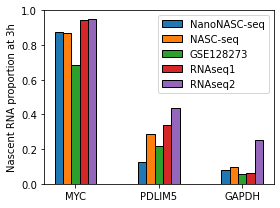

In [174]:
# star genes

tids = ["ENST00000652288.1", "ENST00000317968.9", "ENST00000229239.10"]
gnames = ["MYC", "PDLIM5", "GAPDH"]

array = []
tmp = d1.loc[gnames]
vs = tmp["Nascent"] / tmp["Total"]
array.append(vs.values)

tmp = d2.loc[tids]
vs = tmp["Count[Nascent]"] / tmp["Count"]
array.append(vs.values)

tmp = d3.loc[tids]
vs = tmp["Count[Nascent]"] / tmp["Count"]
array.append(vs.values)

tmp = d4.loc[tids]
vs = 1 - 2 ** (-3/tmp["T"])
array.append(vs.values)

tmp = d5.loc[tids]
vs = 1 - 2 ** (-3/tmp["T"])
array.append(vs.values)

xs = np.arange(3)
labels = ["NanoNASC-seq", "NASC-seq", "GSE128273", "RNAseq1", "RNAseq2"]
plt.figure(figsize=(4, 3))

for i, vs in enumerate(array):
    plt.bar(xs + (i - 2) * 0.1, vs, width=0.1, label=labels[i], edgecolor="black")
plt.xticks(xs, gnames)
plt.ylabel("Nascent RNA proportion at 3h")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig("figures/star_gene_nascent_proportion.pdf", dpi=300)

4604


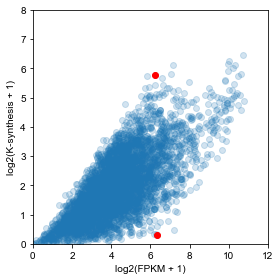

In [4]:
tmp = d4.copy()
tmp["A0"] = tmp[["0h-1_fpkm", "0h-2_fpkm"]].mean(axis=1)
tmp["Ksyn"] = tmp["A0"] * np.log(2) / tmp["T"]
tmp = tmp[tmp["Canonical"]]
tmp = tmp[tmp["GeneType"] == "protein_coding"]
tmp = tmp[tmp["D"] < 0.2]
print(len(tmp))

xs = np.log2(tmp["A0"].values + 1)
ys = np.log2(tmp["Ksyn"].values + 1)

plt.figure(figsize=(4, 4))
plt.scatter(xs, ys, alpha=0.2)
if True:
    tmp1 = tmp[(tmp["A0"] > 64) & (tmp["A0"] < 80)]
    tmp1 = tmp1.sort_values(by="Ksyn")
    tmp1 = tmp1.iloc[[0, -1]]
    xs1 = np.log2(tmp1["A0"].values + 1)
    ys1 = np.log2(tmp1["Ksyn"].values + 1)
    plt.scatter(xs1, ys1, color="red")    
plt.xlabel("log2(FPKM + 1)")
plt.ylabel("log2(K-synthesis + 1)")
plt.xlim(0, 12)
plt.ylim(0, 8)
plt.tight_layout()
# plt.show()
plt.savefig("figures/synthesis_vs_expression.pdf", dpi=300)

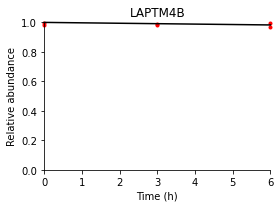

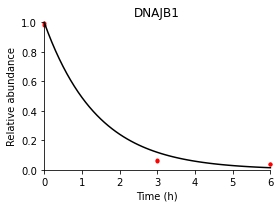

In [200]:
for i in range(len(tmp1)):
    
    xs = np.arange(0, 6.1, 0.1)
    T = tmp1.iloc[i]["T"]
    ys = [2 ** (-x/T) for x in xs]
    
    xs1 = [0, 0, 3, 3, 6, 6]
    ys1 = tmp1.iloc[i][["0h-1_adj_p", "0h-2_adj_p", "3h-1_adj_p", "3h-2_adj_p", "6h-1_adj_p", "6h-2_adj_p"]].values
    
    plt.figure(figsize=(4, 3))
    plt.title(tmp1.iloc[i]["GeneName"])
    plt.plot(xs, ys, color="black", clip_on=False)
    plt.scatter(xs1, ys1, color="red", marker=".", clip_on=False)
    plt.xlabel("Time (h)")
    plt.ylabel("Relative abundance")
    plt.xlim(0, 6)
    plt.ylim(0, 1)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/gene_abundance_%s.pdf" % tmp1.iloc[i]["GeneName"], dpi=300)

In [204]:
d1.loc["LAPTM4B"], d1.loc["DNAJB1"]

(Total                            152
 Nascent                            5
 TPM                          212.266
 T                            62.1695
 Confidence                     False
 TranscriptID       ENST00000619747.1
 TranscriptType        protein_coding
 GeneID            ENSG00000104341.17
 GeneType              protein_coding
 Chrom                           chr8
 Start                       97775056
 End                         97852598
 Strand                             +
 Canonical                      False
 Name: LAPTM4B, dtype: object,
 Total                            36
 Nascent                          33
 TPM                         50.2736
 T                          0.836829
 Confidence                    False
 TranscriptID      ENST00000676577.1
 TranscriptType       protein_coding
 GeneID            ENSG00000132002.9
 GeneType             protein_coding
 Chrom                         chr19
 Start                      14514768
 End                        14

In [206]:
tmp1[tmp1.columns[:2]].mean(axis=1)

TranscriptID
ENST00000521545.7    79.319846
ENST00000254322.3    75.551583
dtype: float64

In [5]:
tmp1 = tmp[(tmp["A0"] > 100) & (tmp["A0"] < 200)]
print(len(tmp1))
tmp1 = tmp1.sort_values(by="Ksyn")
tmp1 = tmp1[["GeneName", "A0", "Ksyn", "T", "Chrom", "Start", "End"]]
tmp1.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1]]

229


,GeneName,A0,Ksyn,T,Chrom,Start,End
TranscriptID,,,,,,,
ENST00000456793.2,OST4,147.011638,0.379041,268.838513,chr2,27070471,27071654
ENST00000544301.7,VIM,116.914888,0.728214,111.284831,chr10,17228240,17237593
ENST00000644362.1,PGK1,165.005746,1.100448,103.933373,chrX,77910738,78126949
ENST00000380377.9,TBCA,152.660458,1.162466,91.027308,chr5,77691165,77776339
ENST00000404824.2,PDIA6,115.528548,1.232921,64.950049,chr2,10783860,10837977
ENST00000340541.4,VAPA,168.077446,37.342661,3.119821,chr18,9914061,9954358
ENST00000264824.5,LYL1,114.222014,38.799197,2.040575,chr19,13099032,13102858
ENST00000614830.5,NOP16,124.469651,39.624440,2.177338,chr5,176383945,176388598
ENST00000373509.6,PIM1,130.330997,55.219810,1.635981,chr6,37170151,37175428


In [92]:
a = {
    "ATACseq": "../encode_k562_atacseq/ENCFF357GNC.bigWig",
    "H3K4me1_1": "../encode_k562_chipseq/H3K4me1/ENCFF839DZV_H3K4me1_rep1.bw",
    "H3K4me1_2": "../encode_k562_chipseq/H3K4me1/ENCFF103WYN_H3K4me1_rep2.bw",
    "H3K4me1_3": "../encode_k562_chipseq/H3K4me1/ENCFF625ZHC_H3K4me1_rep3.bw",
    "H3K4me3_1": "../encode_k562_chipseq/H3K4me3/ENCFF855ZMQ_H3K4me3_rep1.bw",
    "H3K4me3_2": "../encode_k562_chipseq/H3K4me3/ENCFF752MYF_H3K4me3_rep2.bw",
    "H3K27ac_1": "../encode_k562_chipseq/H3K27ac/ENCFF600THN_H3K27ac_rep1.bw",
    "H3K27ac_2": "../encode_k562_chipseq/H3K27ac/ENCFF423WAK_H2K27ac_rep2.bw"
}

for name, path in a.items():
    for i in range(2):
        if i == 0:
            # split by A0
            df1 = tmp[(tmp["A0"] >= 1) & (tmp["A0"] < 10)]
            df2 = tmp[(tmp["A0"] >= 10) & (tmp["A0"] < 30)]
            df3 = tmp[(tmp["A0"] >= 30) & (tmp["A0"] < 50000)]
            title = "%s, split by A0" % name
            # print(len(tmp))
            # len(df1), len(df2), len(df3)
        else:
            # split by Ksyn
            tmp1 = tmp[(tmp["A0"] >= 30) & (tmp["A0"] < 5000)]
            tmp1 = tmp1.sort_values(by="Ksyn")
            # print(len(tmp1))
            n = int(len(tmp1) / 3)
            df1 = tmp1.iloc[:n]
            df2 = tmp1.iloc[n:-n]
            df3 = tmp1.iloc[-n:]
            title = "%s, split by Ksyn" % name
            # len(df1), len(df2), len(df3)
        
        array1 = []
        print(path)
        with pyBigWig.open(path) as f:
            for df in [df1, df2, df3]:
                array = []
                for chrom, start, end, strand in df[["Chrom", "Start", "End", "Strand"]].values:
                    if strand == "+":
                        x, y = start - 5000, start + 5000
                    else:
                        x, y = end - 5000, end + 5000
                    vs = np.nan_to_num(f.values(chrom, x, y), 0)
                    if strand == "-":
                        vs = vs[::-1]
                    array.append(vs)
                array1.append(array)    
        
        xs = np.arange(-5000, 5000)
        labels = ["Low", "Medium", "High"]
        plt.figure(figsize=(4, 3))
        plt.title(title)
        
        for j, array in enumerate(array1):
            ys1 = np.mean(array, axis=0)
            plt.plot(xs, ys1, label=labels[j])
        plt.xticks([-5000, -2500, 0, 2500, 5000], ["-5000", "-2500", "TTS", "2500", "5000"])
        plt.legend()
        plt.tight_layout() 
        plt.savefig("figures/%s.%s.pdf" % (name, "A0" if i == 0 else "Ksyn"), dpi=300)
        plt.close()

../encode_k562_atacseq/ENCFF357GNC.bigWig
../encode_k562_atacseq/ENCFF357GNC.bigWig


In [14]:
# NanoNASC-seq
tmp = d1.copy()
tmp["TPM"] = d1["Total"] * 1e6 / d1["Total"].sum()
tmp["A0"] = tmp["TPM"]
tmp["Ksyn"] = tmp["A0"] * np.log(2) / tmp["T"]
tmp = tmp[tmp["A0"] >= 20]

# ActD
# tmp = d4.copy()
# tmp["A0"] = tmp[["0h-1_fpkm", "0h-2_fpkm"]].mean(axis=1)
# tmp = tmp[tmp["D"] < 0.2]
# tmp = tmp[tmp["A0"] >= 10]

tmp["Ksyn"] = tmp["A0"] * np.log(2) / tmp["T"]
tmp = tmp[tmp["Canonical"]]
tmp = tmp[tmp["GeneType"] == "protein_coding"]

len(tmp)

5121

--------------------------------------------------------------------------------
name: H3K27ac_signal_pval
bw: ../encode_k562_chipseq/H3K27ac/ENCFF465GBD_H3K27ac_signal_pval.bigWig
bed: ../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz
1707 1707 1707
Low 30222.12260208949
Medium 30026.761177989614
High 34071.72584156224


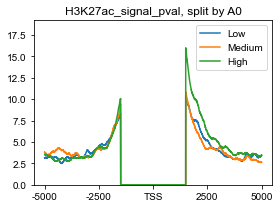

1707 1707 1707
Low 24465.31397217185
Medium 29652.813478990294
High 40202.4821704789


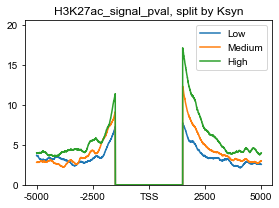

--------------------------------------------------------------------------------
name: H3K27ac_rep1
bw: ../encode_k562_chipseq/H3K27ac/ENCFF600THN_H3K27ac_rep1.bw
bed: ../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz
1707 1707 1707
Low 3675.62331575864
Medium 3859.618629173991
High 4457.9976567076865


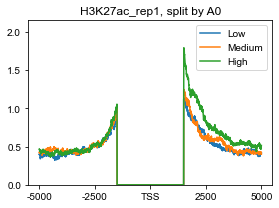

1707 1707 1707
Low 3180.5196250732315
Medium 3779.3960164030445
High 5033.3239601640225


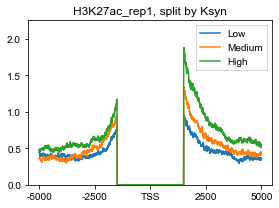

--------------------------------------------------------------------------------
name: H3K27ac_fc_rep1
bw: ../encode_k562_chipseq/H3K27ac/ENCFF177JXC_H2K27ac_rep1_fold_change_over_control.bigWig
bed: ../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz
1707 1707 1707
Low 14713.70826379423
Medium 15658.360995807188
High 17617.832308839832


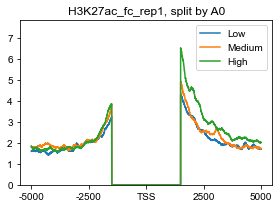

1707 1707 1707
Low 13221.641196578266
Medium 15550.303455462517
High 19217.956916400486


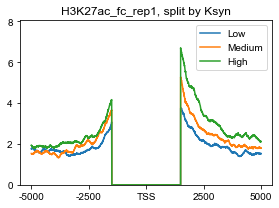

--------------------------------------------------------------------------------
name: H3K27ac_rep2
bw: ../encode_k562_chipseq/H3K27ac/ENCFF423WAK_H2K27ac_rep2.bw
bed: ../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz
1707 1707 1707
Low 3004.9519625073062
Medium 3107.6549502050366
High 3543.0785002929106


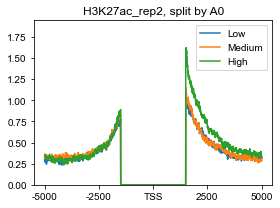

1707 1707 1707
Low 2649.6461628588218
Medium 3104.827182190972
High 3901.2120679554737


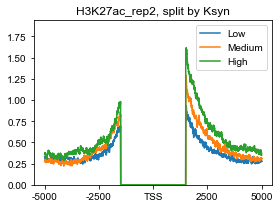

--------------------------------------------------------------------------------
name: H3K4me1_rep3
bw: ../encode_k562_chipseq/H3K4me1/ENCFF625ZHC_H3K4me1_rep3.bw
bed: ../encode_k562_chipseq/H3K4me1/ENCFF135ZLM_H3K4me1_replicated_peaks.bed.gz
1707 1707 1707
Low 8182.510837727006
Medium 8187.623901581736
High 8622.182776801392


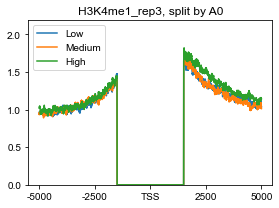

1707 1707 1707
Low 7958.676039835959
Medium 8234.671353251328
High 8798.970123022871


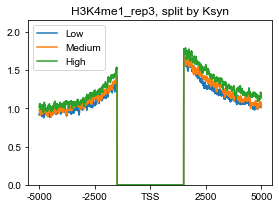

--------------------------------------------------------------------------------
name: H3K4me3_rep1
bw: ../encode_k562_chipseq/H3K4me3/ENCFF855ZMQ_H3K4me3_rep1.bw
bed: ../encode_k562_chipseq/H3K4me3/ENCFF885FQN_H3K4me3_pseudoreplicated_peaks.bed.gz
1707 1707 1707
Low 6042.6578793204535
Medium 5950.353251318103
High 7051.242530755735


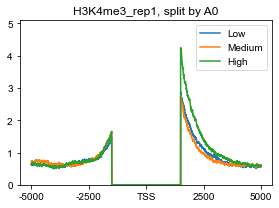

1707 1707 1707
Low 5025.125951962494
Medium 5983.511423550082
High 8035.616285881696


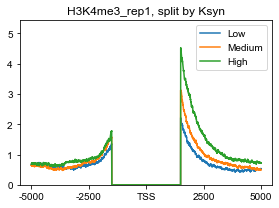

In [16]:
config = {
    "H3K27ac_signal_pval": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF465GBD_H3K27ac_signal_pval.bigWig",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    },
    "H3K27ac_rep1": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF600THN_H3K27ac_rep1.bw",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    },
    "H3K27ac_fc_rep1": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF177JXC_H2K27ac_rep1_fold_change_over_control.bigWig",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    },
    "H3K27ac_rep2": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF423WAK_H2K27ac_rep2.bw",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    },
    "H3K4me1_rep3": {
        "bw": "../encode_k562_chipseq/H3K4me1/ENCFF625ZHC_H3K4me1_rep3.bw",
        "bed": "../encode_k562_chipseq/H3K4me1/ENCFF135ZLM_H3K4me1_replicated_peaks.bed.gz"
    },
    "H3K4me3_rep1": {
        "bw": "../encode_k562_chipseq/H3K4me3/ENCFF855ZMQ_H3K4me3_rep1.bw",
        "bed": "../encode_k562_chipseq/H3K4me3/ENCFF885FQN_H3K4me3_pseudoreplicated_peaks.bed.gz"
    }
}

for name, paths in config.items():
    bw = paths["bw"]
    bed = paths["bed"]
    print("-" * 80)
    print("name:", name)
    print("bw:", bw)
    print("bed:", bed)
    
    with pyBigWig.open(bw) as f:
        chrom_lengths = f.chroms()

    peaks = dict()
    for chrom, length in chrom_lengths.items():
        peaks[chrom] = np.zeros(length, dtype=np.int)
        
    with gzip.open(bed, "rt") as f:
        for line in f:
            chrom, start, end = line.split("\t")[:3]
            start, end = int(start), int(end)
            vs = peaks[chrom]
            for pos in range(start, end):
                vs[pos] = 1   


    for i in range(2):
        if i == 0:
            # split by A0
            n = int(len(tmp)/3)
            tmp1 = tmp.sort_values(by="A0")
            df1 = tmp1.iloc[:n]
            df2 = tmp1.iloc[n:-n]
            df3 = tmp1.iloc[-n:]
            title = "%s, split by A0" % name
            print(len(df1), len(df2), len(df3))
        else:
            # split by Ksyn
            tmp1 = tmp.sort_values(by="Ksyn")
            n = int(len(tmp1) / 3)
            df1 = tmp1.iloc[:n]
            df2 = tmp1.iloc[n:-n]
            df3 = tmp1.iloc[-n:]
            title = "%s, split by Ksyn" % name
            print(len(df1), len(df2), len(df3))

        array1 = []
        with pyBigWig.open(bw) as f:
            for df in [df1, df2, df3]:
                array = []
                for chrom, start, end, strand in df[["Chrom", "Start", "End", "Strand"]].values:
                    if strand == "+":
                        x, y = start - 5000, start + 5000
                    else:
                        x, y = end - 5000, end + 5000
                    vs = np.nan_to_num(f.values(chrom, x, y), 0)
                    vs2 = peaks[chrom][x:y]
                    #for j in range(len(vs)):
                    #    vs[j] = vs[j] if vs2[j] != 0 else 0
                    vs = vs if strand == "+" else vs[::-1]
                    for j in range(-1500, 1500):
                        vs[j + 5000] = 0
                    array.append(vs)
                array1.append(array)

        xs = np.arange(-5000, 5000)
        labels = ["Low", "Medium", "High"]
        
        plt.figure(figsize=(4, 3))
        plt.title(title)
        ymax = 0
        for j, array in enumerate(array1):
            ys1 = np.mean(array, axis=0)
            ymax = max(ymax, max(ys1))
            print(labels[j], sum(ys1))
            plt.plot(xs, ys1, label=labels[j])
        plt.xticks([-5000, -2500, 0, 2500, 5000], ["-5000", "-2500", "TSS", "2500", "5000"])
        plt.ylim(0, ymax * 1.2)
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        # plt.savefig("figures/%s.%s.pdf" % (name, "A0" if i == 0 else "Ksyn"), dpi=300)
        plt.close()
        # break

--------------------------------------------------------------------------------
name: H3K27ac_signal_pval
bw: ../encode_k562_chipseq/H3K27ac/ENCFF465GBD_H3K27ac_signal_pval.bigWig
bed: ../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz
703 704 703
Low 23720.871373446163
Medium 31280.780517745723
High 34589.42547224701


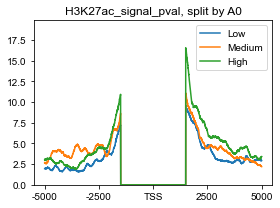

703 704 703
Low 22713.270432130586
Medium 28658.740136111086
High 38222.79658236896


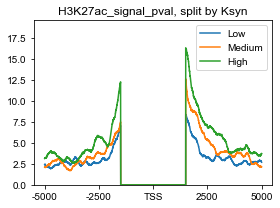

--------------------------------------------------------------------------------
name: H3K27ac_rep1
bw: ../encode_k562_chipseq/H3K27ac/ENCFF600THN_H3K27ac_rep1.bw
bed: ../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz
703 704 703
Low 3189.736842105263
Medium 3877.556818181811
High 4418.6230440967765


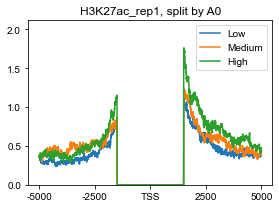

703 704 703
Low 3071.3044096728304
Medium 3683.384943181829
High 4731.503556187772


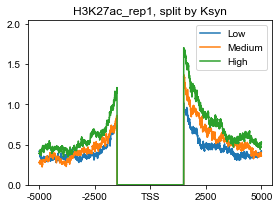

--------------------------------------------------------------------------------
name: H3K27ac_rep2
bw: ../encode_k562_chipseq/H3K27ac/ENCFF423WAK_H2K27ac_rep2.bw
bed: ../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz
703 704 703
Low 2574.1906116642863
Medium 3168.080965909086
High 3621.7880512090833


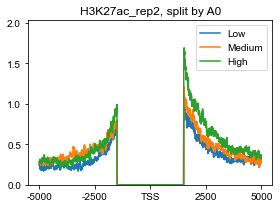

703 704 703
Low 2522.9217638691425
Medium 3050.927556818176
High 3790.3769559032617


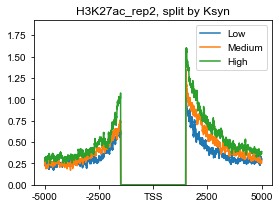

--------------------------------------------------------------------------------
name: H3K4me1_rep3
bw: ../encode_k562_chipseq/H3K4me1/ENCFF625ZHC_H3K4me1_rep3.bw
bed: ../encode_k562_chipseq/H3K4me1/ENCFF135ZLM_H3K4me1_replicated_peaks.bed.gz
703 704 703
Low 8145.3058321480175
Medium 8054.552556818189
High 8660.97297297305


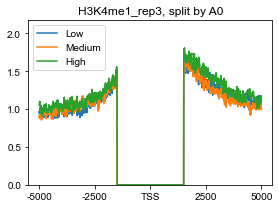

703 704 703
Low 7876.399715505048
Medium 8173.565340909105
High 8810.697012802317


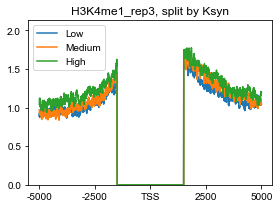

--------------------------------------------------------------------------------
name: H3K4me3_rep1
bw: ../encode_k562_chipseq/H3K4me3/ENCFF855ZMQ_H3K4me3_rep1.bw
bed: ../encode_k562_chipseq/H3K4me3/ENCFF885FQN_H3K4me3_pseudoreplicated_peaks.bed.gz
703 704 703
Low 5794.519203413931
Medium 5960.032670454566
High 7324.698435277388


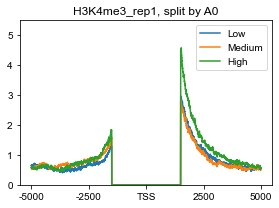

703 704 703
Low 4788.980085348517
Medium 6142.794034090933
High 8147.216216216206


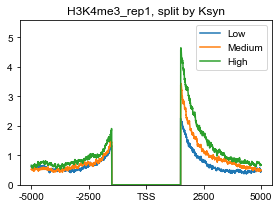

In [15]:
config = {
    "H3K27ac_signal_pval": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF465GBD_H3K27ac_signal_pval.bigWig",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    },
    "H3K27ac_rep1": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF600THN_H3K27ac_rep1.bw",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    },
    "H3K27ac_fc_rep1": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF177JXC_H2K27ac_rep1_fold_change_over_control.bigWig",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    }
    "H3K27ac_rep2": {
        "bw": "../encode_k562_chipseq/H3K27ac/ENCFF423WAK_H2K27ac_rep2.bw",
        "bed": "../encode_k562_chipseq/H3K27ac/ENCFF544LXB_h3K27ac_pseudoreplicated_peaks.bed.gz"
    },
    "H3K4me1_rep3": {
        "bw": "../encode_k562_chipseq/H3K4me1/ENCFF625ZHC_H3K4me1_rep3.bw",
        "bed": "../encode_k562_chipseq/H3K4me1/ENCFF135ZLM_H3K4me1_replicated_peaks.bed.gz"
    },
    "H3K4me3_rep1": {
        "bw": "../encode_k562_chipseq/H3K4me3/ENCFF855ZMQ_H3K4me3_rep1.bw",
        "bed": "../encode_k562_chipseq/H3K4me3/ENCFF885FQN_H3K4me3_pseudoreplicated_peaks.bed.gz"
    }
}

for name, paths in config.items():
    bw = paths["bw"]
    bed = paths["bed"]
    print("-" * 80)
    print("name:", name)
    print("bw:", bw)
    print("bed:", bed)
    
    with pyBigWig.open(bw) as f:
        chrom_lengths = f.chroms()

    peaks = dict()
    for chrom, length in chrom_lengths.items():
        peaks[chrom] = np.zeros(length, dtype=np.int)
        
    with gzip.open(bed, "rt") as f:
        for line in f:
            chrom, start, end = line.split("\t")[:3]
            start, end = int(start), int(end)
            vs = peaks[chrom]
            for pos in range(start, end):
                vs[pos] = 1   


    for i in range(2):
        if i == 0:
            # split by A0
            n = int(len(tmp)/3)
            tmp1 = tmp.sort_values(by="A0")
            df1 = tmp1.iloc[:n]
            df2 = tmp1.iloc[n:-n]
            df3 = tmp1.iloc[-n:]
            title = "%s, split by A0" % name
            print(len(df1), len(df2), len(df3))
        else:
            # split by Ksyn
            tmp1 = tmp.sort_values(by="Ksyn")
            n = int(len(tmp1) / 3)
            df1 = tmp1.iloc[:n]
            df2 = tmp1.iloc[n:-n]
            df3 = tmp1.iloc[-n:]
            title = "%s, split by Ksyn" % name
            print(len(df1), len(df2), len(df3))

        array1 = []
        with pyBigWig.open(bw) as f:
            for df in [df1, df2, df3]:
                array = []
                for chrom, start, end, strand in df[["Chrom", "Start", "End", "Strand"]].values:
                    if strand == "+":
                        x, y = start - 5000, start + 5000
                    else:
                        x, y = end - 5000, end + 5000
                    vs = np.nan_to_num(f.values(chrom, x, y), 0)
                    vs2 = peaks[chrom][x:y]
                    #for j in range(len(vs)):
                    #    vs[j] = vs[j] if vs2[j] != 0 else 0
                    vs = vs if strand == "+" else vs[::-1]
                    for j in range(-1500, 1500):
                        vs[j + 5000] = 0
                    array.append(vs)
                array1.append(array)

        xs = np.arange(-5000, 5000)
        labels = ["Low", "Medium", "High"]
        
        plt.figure(figsize=(4, 3))
        plt.title(title)
        ymax = 0
        for j, array in enumerate(array1):
            ys1 = np.mean(array, axis=0)
            ymax = max(ymax, max(ys1))
            print(labels[j], sum(ys1))
            plt.plot(xs, ys1, label=labels[j])
        plt.xticks([-5000, -2500, 0, 2500, 5000], ["-5000", "-2500", "TSS", "2500", "5000"])
        plt.ylim(0, ymax * 1.2)
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        # plt.savefig("figures/%s.%s.pdf" % (name, "A0" if i == 0 else "Ksyn"), dpi=300)
        plt.close()
        # break